In [34]:
import torch
import torchvision
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
import time

%matplotlib inline

# 前期数据准备,下载Kaggle网站的DogsVSCats数据集,从训练集抽各取猫、狗2500组成验证集
data_dir = "./data/DogsVSCats"
data_transform = {x : transforms.Compose([transforms.Resize([64, 64]),
                                         transforms.ToTensor()])
                     for x in ["train", "valid"]}
image_datasets = {x : datasets.ImageFolder(root=os.path.join(data_dir, x),
                                        transform=data_transform[x])
                     for x in ["train", "valid"]}
dataloader = {x : torch.utils.data.DataLoader(dataset=image_datasets[x],
                                             batch_size=16,
                                             shuffle=True)
                 for x in ["train", "valid"]}

In [35]:
X_example, y_example = next(iter(dataloader["train"]))

In [36]:
y_example.data

tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1])

In [37]:
# 进行数据装载时已经对dog和cat文件夹下的内容进行了独热编码(One-Hot Encoding)
index_classes = image_datasets["train"].class_to_idx
print(index_classes)

{'cat': 0, 'dog': 1}


In [47]:
example_classes = image_datasets["valid"].classes
print(example_classes)

['cat', 'dog']


['cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog']


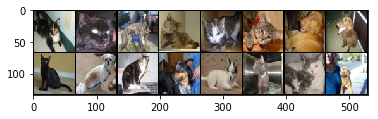

In [48]:
# 可视化一批数据
img = torchvision.utils.make_grid(X_example)
img = img.numpy().transpose([1,2,0])
print([example_classes[i] for i in y_example])
plt.imshow(img)
plt.show()

In [68]:
# 搭建一个简化版的VGGNet神经网络模型
class Models(torch.nn.Module):
    
    def __init__(self):
        super(Models, self).__init__()
        self.Conv = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.Classes = torch.nn.Sequential(
            torch.nn.Linear(4*4*512, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(1024, 2)
        )
        
    def forward(self, input):
        x = self.Conv(input)
        x = x.view(-1, 4*4*512)
        x = self.Classes(x)
        return x

In [69]:
model = Models()
print(model)

Models(
  (Conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padd

In [71]:
# 定义损失函数、优化器,并进行模型训练
from torch.autograd import Variable

loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

epoch_n = 10
time_open = time.time()

for epoch in range(epoch_n):
    print("Epoch {}/{}".format(epoch, epoch_n - 1))
    print("-"*10)
    
    for phase in ["train", "valid"]:
        if phase == "train":
            print("Training...")
            model.train(True)
        else:
            print("Validing...")
            model.train(False)
        running_loss = 0.0
        running_corrects = 0
        
        for batch, data in enumerate(dataloader[phase], 1):
            X, y = data

            X, y = Variable(X), Variable(y)

            y_pred = model(X)

            _, pred = torch.max(y_pred.data, 1)

            optimizer.zero_grad()

            loss = loss_f(y_pred, y)

            if phase == "train":
                loss.backward()
                optimizer.step()

            running_loss += loss.data
            running_corrects += torch.sum(pred==y.data)

            if batch%500 == 0 and phase == "train":
                print("Batch{}, Train Loss:{:.4f}, Train Acc:{:.4f}%".format(
                batch, torch.true_divide(running_loss,batch),
                        torch.true_divide(100*running_corrects, 16*batch)))
                
        epoch_loss = torch.true_divide(running_loss*16, 
                                           len(image_datasets[phase]))
        epoch_acc = torch.true_divide(100*running_corrects,
                                         len(image_datasets[phase]))
        print("{} Loss:{:.4f} Acc:{:.4f}%".format(phase, epoch_loss, epoch_acc))
time_end = time.time() - time_open
print("Use time:", time_end)
            

Epoch 0/9
----------
Training...
Batch500, Train Loss:0.6932, Train Acc:49.4875%
Batch1000, Train Loss:0.6932, Train Acc:49.9688%
train Loss:0.6929 Acc:50.4500%
Validing...
valid Loss:0.6928 Acc:51.5400%
Epoch 1/9
----------
Training...
Batch500, Train Loss:0.6760, Train Acc:57.4250%
Batch1000, Train Loss:0.6660, Train Acc:59.1875%
train Loss:0.6619 Acc:59.9750%
Validing...
valid Loss:0.6424 Acc:63.4800%
Epoch 2/9
----------
Training...
Batch500, Train Loss:0.6343, Train Acc:63.9250%
Batch1000, Train Loss:0.6285, Train Acc:64.8562%
train Loss:0.6292 Acc:64.6950%
Validing...
valid Loss:0.6162 Acc:66.5400%
Epoch 3/9
----------
Training...
Batch500, Train Loss:0.6205, Train Acc:66.1500%
Batch1000, Train Loss:0.6106, Train Acc:67.0125%
train Loss:0.6087 Acc:67.1550%
Validing...
valid Loss:0.5899 Acc:69.8400%
Epoch 4/9
----------
Training...
Batch500, Train Loss:0.6000, Train Acc:68.0500%
Batch1000, Train Loss:0.5944, Train Acc:68.6312%
train Loss:0.5916 Acc:68.8500%
Validing...
valid Loss:

In [74]:
# 查看GPU是否可用
print(torch.cuda.is_available())

False


In [ ]:
# 使用GPU进行计算
Use_gpu = torch.cuda.is_available()
if Use_gpu:
    model = model.cuda()  # 模型切换为使用GPU进行计算
    
epoch_n = 10
time_open = time.time()

for epoch in range(epoch_n):
    print("Epoch {}/{}".format(epoch, epoch_n - 1))
    print("-"*10)
    
    for phase in ["train", "valid"]:
        if phase == "train":
            print("Training...")
            model.train(True)
        else:
            print("Validing...")
            model.train(False)
        running_loss = 0.0
        running_corrects = 0
        
        for batch, data in enumerate(dataloader[phase], 1):
            X, y = data
            if Use_gpu:
                X, y = Variable(X.cuda()), Variable(y.cuda()) # 数据计算使用GPU
            else:
                X, y = Variable(X), Variable(y)

            y_pred = model(X)

            _, pred = torch.max(y_pred.data, 1)

            optimizer.zero_grad()

            loss = loss_f(y_pred, y)

            if phase == "train":
                loss.backward()
                optimizer.step()

            running_loss += loss.data
            running_corrects += torch.sum(pred==y.data)

            if batch%500 == 0 and phase == "train":
                print("Batch{}, Train Loss:{:.4f}, Train Acc:{:.4f}%".format(
                batch, torch.true_divide(running_loss,batch),
                        torch.true_divide(100*running_corrects, 16*batch)))
                
        epoch_loss = torch.true_divide(running_loss*16, 
                                           len(image_datasets[phase]))
        epoch_acc = torch.true_divide(100*running_corrects,
                                         len(image_datasets[phase]))
        print("{} Loss:{:.4f} Acc:{:.4f}%".format(phase, epoch_loss, epoch_acc))
time_end = time.time() - time_open
print("Use time:", time_end)

In [77]:
# 使用VGG16模型进行迁移学习
from torchvision import models

#下载vgg16模型
model = models.vgg16(pretrained=True) # pretrained参数用于设置是否附带已优化的参数
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [79]:
# 调整模型的全连接层，改变输出结果
# 冻结全连接层之前的全部网络层次，让这些被冻结的网络层次中的参数在模型的训练过程中
# 不进行梯度更新，仅仅能够优化全连接层的参数
for parma in model.parameters():
    parma.requires_grad = False # 设置参数梯度更新为False，进行冻结

# 重新定义全连接层，parma.requires_grad参数默认为True
model.classifier = torch.nn.Sequential(
                        torch.nn.Linear(25088, 4096),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.5),
                        torch.nn.Linear(4096, 4096),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.5),
                        torch.nn.Linear(4096, 2))

Use_gpu = torch.cuda.is_available()
if Use_gpu:
    model = model.cuda()
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.00001)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat']


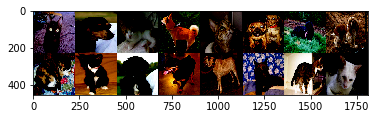

Epoch 0/-1
----------
Training...
Batch500, Train Loss:0.1019, Train Acc:96.4875%
Batch1000, Train Loss:0.0760, Train Acc:97.2750%
train Loss:0.0698 Acc:97.4700%
Validing...
valid Loss:0.0513 Acc:98.2800%
Epoch 1/0
----------
Training...
Batch500, Train Loss:0.0198, Train Acc:99.2500%
Batch1000, Train Loss:0.0238, Train Acc:99.1375%
train Loss:0.0248 Acc:99.1100%
Validing...
valid Loss:0.0762 Acc:97.8800%
Epoch 2/1
----------
Training...
Batch500, Train Loss:0.0107, Train Acc:99.7250%
Batch1000, Train Loss:0.0100, Train Acc:99.7250%
train Loss:0.0099 Acc:99.7100%
Validing...
valid Loss:0.0700 Acc:98.3800%
Epoch 3/2
----------
Training...
Batch500, Train Loss:0.0026, Train Acc:99.9500%
Batch1000, Train Loss:0.0030, Train Acc:99.9313%
train Loss:0.0047 Acc:99.8850%
Validing...
valid Loss:0.0941 Acc:98.1200%
Epoch 4/3
----------
Training...
Batch500, Train Loss:0.0014, Train Acc:99.9625%
Batch1000, Train Loss:0.0015, Train Acc:99.9688%
train Loss:0.0018 Acc:99.9600%
Validing...
valid Loss

In [90]:
# 对迁移模型进行训练
import torch
import torchvision
from torchvision import datasets, models, transforms
import os
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import time


data_dir = "./data/DogsVSCats"
data_transform = {x : transforms.Compose([transforms.Scale([224, 224]),
                                         transforms.ToTensor(),
                                         transforms.Normalize(
                                         mean=[0.5,0.5,0.5],
                                         std=[0.5,0.5,0.5])])
                        for x in ["train", "valid"]}
image_datasets = {x : datasets.ImageFolder(root=os.path.join(data_dir, x),
                                          transform= data_transform[x])
                         for x in ["train", "valid"]}
dataloader = {x : torch.utils.data.DataLoader(dataset=image_datasets[x],
                                             batch_size=16,
                                             shuffle=True)
                         for x in ["train", "valid"]}

X_example, y_example = next(iter(dataloader["train"]))
example_calsses = image_datasets["train"].classes
img = torchvision.utils.make_grid(X_example)
img = img.numpy().transpose([1,2,0])
print([example_classes[i] for i in y_example])
plt.imshow(img)
plt.show()

model = models.vgg16(pretrained=True)
for parma in model.parameters():
    parma.requires_grad = False
    
model.classifier = torch.nn.Sequential(
                        torch.nn.Linear(25088, 4096),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.5),
                        torch.nn.Linear(4096, 4096),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.5),
                        torch.nn.Linear(4096, 2))
Use_gpu = torch.cuda.is_available()
if Use_gpu:
    model = model.cuda()

loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.00001)

epoch_n = 5
time_open = time.time()

for epoch in range(epoch_n):
    print("Epoch {}/{}".format(epoch, epoch_n-1))
    print("-"*10)
    
    for phase in {"train", "valid"}:
        if phase == "train":
            print("Training...")
            model.train(True)
        else:
            print("Validing...")
            model.train(False)
            
        running_loss = 0
        running_corrects = 0
        
        for batch, data in enumerate(dataloader[phase], 1):
            X, y = data
            if Use_gpu:
                X, y = Variable(X.cuda()), Variable(y.cuda())
            else:
                X, y = Variable(X), Variable(y)
            
            y_pred = model(X)
            _, pred = torch.max(y_pred.data, 1)
            
            optimizer.zero_grad()
            loss = loss_f(y_pred, y)
            
            if phase == "train":
                loss.backward()
                optimizer.step()
            running_loss += loss.data
            running_corrects += torch.sum(pred == y.data)
            
            cal = torch.true_divide
            if batch%500 == 0 and phase == "train":
                print("Batch{}, Train Loss:{:.4f}, Train Acc:{:.4f}%".format(
                batch, cal(running_loss,batch),
                    cal(100*running_corrects,16*batch)))
                
        epoch_loss = cal(running_loss*16, len(image_datasets[phase]))
        epoch_acc = cal(100*running_corrects,len(image_datasets[phase]))
        print("{} Loss:{:.4f} Acc:{:.4f}%".format(phase, epoch_loss, epoch_acc))
time_end = time.time() - time_open
print("Use time:", time_end)

['cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


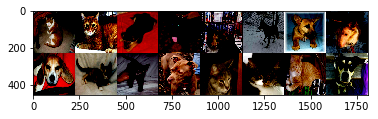

Epoch 0/4
----------
Training...
Batch500, Train Loss:0.5759, Train Acc:76.6375%
Batch1000, Train Loss:0.4836, Train Acc:85.0000%
train Loss:0.4503 Acc:86.9350%
Validing...
valid Loss:0.2721 Acc:96.6400%
Epoch 1/4
----------
Training...
Batch500, Train Loss:0.2702, Train Acc:95.3500%
Batch1000, Train Loss:0.2498, Train Acc:95.3625%
train Loss:0.2417 Acc:95.4150%
Validing...
valid Loss:0.1692 Acc:97.4200%
Epoch 2/4
----------
Training...
Batch500, Train Loss:0.1899, Train Acc:96.1125%
Batch1000, Train Loss:0.1826, Train Acc:95.8750%
train Loss:0.1793 Acc:95.8100%
Validing...
valid Loss:0.1277 Acc:97.7000%
Epoch 3/4
----------
Training...
Batch500, Train Loss:0.1565, Train Acc:96.1250%
Batch1000, Train Loss:0.1511, Train Acc:96.0875%
train Loss:0.1508 Acc:96.0450%
Validing...
valid Loss:0.1086 Acc:97.8800%
Epoch 4/4
----------
Training...
Batch500, Train Loss:0.1425, Train Acc:95.7250%
Batch1000, Train Loss:0.1362, Train Acc:96.0250%
train Loss:0.1363 Acc:95.9300%
Validing...
valid Loss:

In [91]:
# 使用ResNet50进行迁移学习
import torch
import torchvision
from torchvision import datasets, models, transforms
import os
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import time


data_dir = "./data/DogsVSCats"
data_transform = {x : transforms.Compose([transforms.Scale([224, 224]),
                                         transforms.ToTensor(),
                                         transforms.Normalize(
                                         mean=[0.5,0.5,0.5],
                                         std=[0.5,0.5,0.5])])
                        for x in ["train", "valid"]}
image_datasets = {x : datasets.ImageFolder(root=os.path.join(data_dir, x),
                                          transform= data_transform[x])
                         for x in ["train", "valid"]}
dataloader = {x : torch.utils.data.DataLoader(dataset=image_datasets[x],
                                             batch_size=16,
                                             shuffle=True)
                         for x in ["train", "valid"]}

X_example, y_example = next(iter(dataloader["train"]))
example_calsses = image_datasets["train"].classes
img = torchvision.utils.make_grid(X_example)
img = img.numpy().transpose([1,2,0])
print([example_classes[i] for i in y_example])
plt.imshow(img)
plt.show()

model = models.resnet50(pretrained=True)
for parma in model.parameters():
    parma.requires_grad = False
    
model.fc = torch.nn.Linear(2048, 2) # 修改全连接层的输出形状
Use_gpu = torch.cuda.is_available()
if Use_gpu:
    model = model.cuda()

loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.00001)

epoch_n = 5
time_open = time.time()

for epoch in range(epoch_n):
    print("Epoch {}/{}".format(epoch, epoch_n-1))
    print("-"*10)
    
    for phase in {"train", "valid"}:
        if phase == "train":
            print("Training...")
            model.train(True)
        else:
            print("Validing...")
            model.train(False)
            
        running_loss = 0
        running_corrects = 0
        
        for batch, data in enumerate(dataloader[phase], 1):
            X, y = data
            if Use_gpu:
                X, y = Variable(X.cuda()), Variable(y.cuda())
            else:
                X, y = Variable(X), Variable(y)
            
            y_pred = model(X)
            _, pred = torch.max(y_pred.data, 1)
            
            optimizer.zero_grad()
            loss = loss_f(y_pred, y)
            
            if phase == "train":
                loss.backward()
                optimizer.step()
            running_loss += loss.data
            running_corrects += torch.sum(pred == y.data)
            
            cal = torch.true_divide
            if batch%500 == 0 and phase == "train":
                print("Batch{}, Train Loss:{:.4f}, Train Acc:{:.4f}%".format(
                batch, cal(running_loss,batch),
                    cal(100*running_corrects,16*batch)))
                
        epoch_loss = cal(running_loss*16, len(image_datasets[phase]))
        epoch_acc = cal(100*running_corrects,len(image_datasets[phase]))
        print("{} Loss:{:.4f} Acc:{:.4f}%".format(phase, epoch_loss, epoch_acc))
time_end = time.time() - time_open
print("Use time:", time_end)